# Exploratory Data Analysis

## Set up environment

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from fuzzywuzzy import process, fuzz

In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [3]:
cwd = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir))

In [4]:
os.listdir(path + 'raw')

['BX-NewBooksUsers.csv',
 'BX-Books.csv',
 'BX-Ratings.csv',
 'BX-Users.csv',
 'BX-NewBooksRatings.csv',
 'BX-NewBooks.csv']

## BX-Books

In [5]:
books = pd.read_csv(path + "raw/BX-Books.csv")
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada
1,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux
2,0399135782,The Kitchen God's Wife,Amy Tan,1991,Putnam Pub Group
3,0440234743,The Testament,John Grisham,1999,Dell
4,0452264464,Beloved (Plume Contemporary Fiction),Toni Morrison,1994,Plume


### Null Values

No null values to deal with

In [6]:
books.isna().sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Book-Publisher         0
dtype: int64

In [7]:
books.dtypes

ISBN                   object
Book-Title             object
Book-Author            object
Year-Of-Publication     int64
Book-Publisher         object
dtype: object

### Year of publication
Year of Publication has max 2030 and min 0. Plot a histogram to see distribution for books published by year.
- 314 books published in year 0.
- 3 books published in year 2030 (not possible)

This imputation needs to be done after text processing on author, title and publisher.

In [8]:
books["Year-Of-Publication"].min(), books["Year-Of-Publication"].max()

(0, 2030)

<Axes: ylabel='Frequency'>

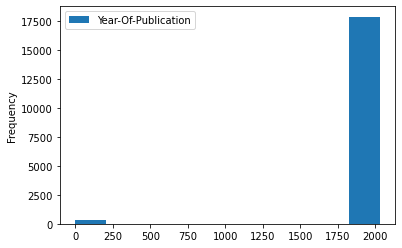

In [9]:
books.plot(kind = "hist", y = "Year-Of-Publication")

/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

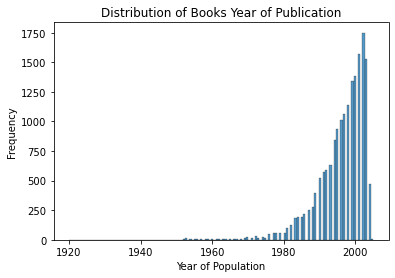

In [159]:
sns.histplot(books[(books['Year-Of-Publication'] != 0) & (books['Year-Of-Publication'] < 2024)], x = 'Year-Of-Publication')
plt.title('Distribution of Books Year of Publication')
plt.xlabel('Year of Population')
plt.ylabel('Frequency')

In [11]:
books.groupby("Year-Of-Publication")["ISBN"].count()

Year-Of-Publication
0        314
1920       2
1927       1
1929       1
1930       1
        ... 
2002    1750
2003    1530
2004     475
2005       3
2030       3
Name: ISBN, Length: 70, dtype: int64

In [12]:
books[books["Year-Of-Publication"] == 0].head(20)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
164,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc
195,3596214629,"Herr Der Fliegen (Fiction, Poetry and Drama)",Golding,0,Fischer Taschenbuch Verlag GmbH
285,8845229041,Biblioteca Universale Rizzoli: Sulla Sponda De...,P Coelho,0,Fabbri - RCS Libri
343,0590021117,Little House On the Prairie,Laura Ingall Wilder,0,Scholastic Inc
395,2070362388,Ravage,Rene Barjavel,0,Gallimard French
441,0718144538,Shattered Uk,Dick Francis,0,Michael Joseph Ltd
444,0349101779,The Wasp Factory,Iain Banks,0,Abacus
488,0753804700,Reader,Bernhard Schlink,0,Phoenix Books
650,0140620338,Picture of Dorian Gray,Oscar Wilde,0,Penguin Putnam~mass
661,000649840X,Angelas Ashes,Frank Mccourt,0,Harpercollins Uk


In [13]:
# babara kingsolver has invalid year, see if there are any other book titles similar. (272)
books[books["Book-Author"] == "Barbara Kingsolver"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
14,0060168013,Pigs in Heaven,Barbara Kingsolver,1993,Harpercollins
164,0571197639,Poisonwood Bible Edition Uk,Barbara Kingsolver,0,Faber Faber Inc
271,0060915544,The Bean Trees,Barbara Kingsolver,1989,Perennial
272,0060917016,Homeland and Other Stories,Barbara Kingsolver,1990,Perennial
722,0060930535,The Poisonwood Bible: A Novel,Barbara Kingsolver,1999,Perennial
975,0060175400,The Poisonwood Bible,Barbara Kingsolver,1999,HarperCollins
1200,0060922532,Pigs in Heaven,Barbara Kingsolver,1994,Perennial
1743,0061097314,The Bean Trees,Barbara Kingsolver,1998,HarperTorch
1749,0060504080,Small Wonder : Essays,Barbara Kingsolver,2003,Perennial
2101,0060199652,Prodigal Summer,Barbara Kingsolver,2000,HarperCollins


In [14]:
# invalid year
books.iloc[164]

ISBN                                    0571197639
Book-Title             Poisonwood Bible Edition Uk
Book-Author                     Barbara Kingsolver
Year-Of-Publication                              0
Book-Publisher                     Faber Faber Inc
Name: 164, dtype: object

In [15]:
# invalid years
books[books["Year-Of-Publication"] >= 2025]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher
11362,0671746103,MY TEACHER FRIED MY BRAINS (RACK SIZE) (MY TEA...,Coville,2030,Aladdin
13687,0671791990,MY TEACHER FLUNKED THE PLANET (RACK SIZE) (MY ...,Bruce Coville,2030,Aladdin
15739,0870449842,Crossing America,National Geographic Society,2030,National Geographic


### ISBN 
Also noticed ISBN is a 10 digit number but some have and X at the end.
- ISBN is a 10 digit number before 2007. This dataset is fine for just 10.
- the only letter wich can be in an ISBN is an X to represent ten.

No duplicates on ISBN

In [16]:
books[~books["ISBN"].str.match(r"^(?=(?:\D*\d){9,10})|\d{9}X")]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher


In [17]:
books[books["ISBN"].duplicated()]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher


### Book-Author
Potential for Authors to be under different naming convention.
- For example Jack Du Brul vs Jack B. Du Brul
    - Do some text analysis in cleaning to give authors same name
- Also text is mix of upper/lowercase - case folding to lowercase.
- Look to see if there are any unknown names
    - unknown
    - Jack


In [18]:
# output of books in dataset by author
author_dist = books.groupby("Book-Author")["ISBN"].count().sort_values(ascending=False).reset_index().rename(columns= {'ISBN':'Count'})

author_dist

,Book-Author,Count
0,Stephen King,193
1,Nora Roberts,123
2,Anne McCaffrey,81
3,Danielle Steel,74
4,Piers Anthony,70
...,...,...
6447,Jack Kersh,1
6448,Jack Handey,1
6449,Jack Du Brul,1
6450,Jack B. Du Brul,1


<Axes: xlabel='Count', ylabel='Book-Author'>

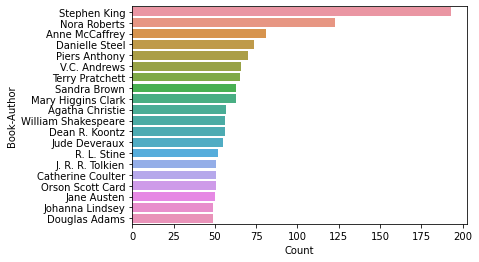

In [19]:
sns.barplot(author_dist.head(20), x = "Count", y = "Book-Author", orient = "h")

<Axes: xlabel='Count', ylabel='Book-Author'>

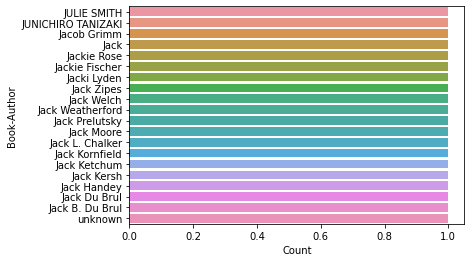

In [20]:
sns.barplot(author_dist.tail(20), x = "Count", y = "Book-Author", orient = "h")

##### Author text cleaning:
- case folding - lower.
- names like o'dell needed special consideration to odell not o dell as there are authors that have inital of middle name.
- consider co-authors with &.
- remove extra spaces.

In [21]:
# Define regex pattern to remove non-alphanumeric characters except '&'
pattern = r'[^a-zA-Z0-9& ]'

# Function to clean text based on regex pattern
def clean_text(text):
    cleaned_text = re.sub(pattern, ' ', text)
    return cleaned_text

In [22]:
def fuzzy_match_comparison(col):
    
    unique = books[f"Book-{col}"].unique()
    print(len(unique))
    
    score_sort = [(x,) + i
             for x in unique
             for i in process.extract(x, unique, scorer=fuzz.ratio)] 
    
    similarity_sort = pd.DataFrame(score_sort, columns=[f'{col}_sort','match_sort','score_sort'])
    similarity_sort[f'sorted_{col}_sort'] = np.minimum(similarity_sort[f'{col}_sort'], similarity_sort['match_sort'])

    high_score_sort = \
    similarity_sort[(similarity_sort['score_sort'] >= 80) & \
                    (similarity_sort[f'{col}_sort'] !=  similarity_sort['match_sort']) & \
                    (similarity_sort[f'sorted_{col}_sort'] != similarity_sort['match_sort'])] 
    high_score_sort = high_score_sort.drop(f'sorted_{col}_sort',axis=1).copy()

    high_score_sort = high_score_sort.groupby([f'{col}_sort','score_sort']).agg(
                        {'match_sort': ', '.join}).sort_values(
                        ['score_sort'], ascending=False).reset_index()

    return high_score_sort

In [23]:
books["Book-Author"].unique().shape

(6452,)

In [24]:
books["Book-Author-Processed"] = books["Book-Author"].str.lower()

In [25]:
books["Book-Author-Processed"] = books["Book-Author-Processed"].str.replace("'", "")
# Remove all non-alphabetic characters by replacing them with a space.
books["Book-Author-Processed"] = books["Book-Author-Processed"].apply(clean_text).str.replace('  ', ' ').str.strip()

In [ ]:
%%time
author_fuzzy_match = fuzzy_match_comparison("Author-Processed")
author_fuzzy_match.shape

In [ ]:
author_fuzzy_match.head()

In [ ]:
author_fuzzy_match.tail()

### Fuzzy matching strings
- Set up function for different columns
- at beginning of processing case fold
    - books["Book-Author"] = books["Book-Author"].str.lower()
- get rid of .,!:- etc.
- some books have similar title. For example:
    - "the beach" vs. "the breach" - similarity = 0.95 but are different authors.
    - "the far side gallery 4" vs. "the far side gallery 5" - similarity = 0.95 but different version in series.
 
- Books will need to be processed. tf-idf? for similar titles?

In [32]:
books["Book-Publisher"] = books["Book-Publisher"].str.lower()

In [33]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
0,0002005018,clara callan,Richard Bruce Wright,2001,harperflamingo canada,richard bruce wright
1,0374157065,flu: the story of the great influenza pandemic...,Gina Bari Kolata,1999,farrar straus giroux,gina bari kolata
2,0399135782,the kitchen god's wife,Amy Tan,1991,putnam pub group,amy tan
3,0440234743,the testament,John Grisham,1999,dell,john grisham
4,0452264464,beloved (plume contemporary fiction),Toni Morrison,1994,plume,toni morrison


In [34]:
books[books["Book-Title"].isin(["prince charming", "princess charming"])]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
6209,0671870963,prince charming,Julie Garwood,1995,pocket,julie garwood
12676,1575662612,princess charming,Jane Heller,1997,kensington publishing corporation,jane heller
17351,0671870955,prince charming,Julie Garwood,1994,atria,julie garwood


In [35]:
%%time
publisher_fuzzy_match = fuzzy_match_comparison("Publisher")
publisher_fuzzy_match

1330
CPU times: user 2.96 s, sys: 130 ms, total: 3.09 s
Wall time: 3.34 s


,Publisher_sort,score_sort,match_sort
0,penguin books australia ltd,100,penguin books australia ltd.
1,scholastic inc,100,scholastic inc.
2,random house trade,100,random house~trade
3,droemersche verlagsanstalt th. knaur nachf. gm...,99,"droemersche verlagsanstalt th. knaur nachf., g..."
4,wilhelm goldmann verlag gmbh,98,"wilhelm goldmann verlag, gmbh"
...,...,...,...
411,living books,80,vintage books
412,livre de poche,80,livre de poche french
413,modern publishing,80,workman publishing
414,mondadori (it),80,mondadori italian


### Book-Title
- Books can be published by other publisher
- Potential for Book-Title to be similar
- Duplicates on Book-Publisher and Book-Title
    - No concern 

<Axes: xlabel='Count', ylabel='Book-Title'>

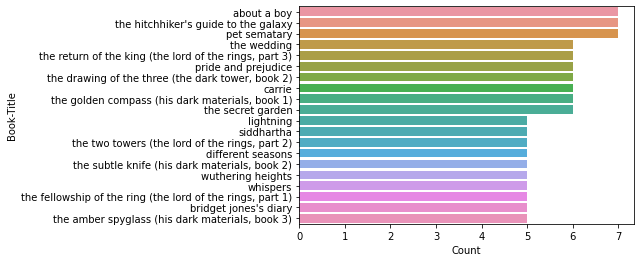

In [36]:
books_title = books.groupby(["Book-Title"])["ISBN"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'ISBN':'Count'})

duplicate_books = books_title[books_title["Count"] > 1]

sns.barplot(duplicate_books.head(20), x = "Count", y = "Book-Title", orient = "h")

In [37]:
books[books["Book-Title"].isin(duplicate_books["Book-Title"])].sort_values(by = "Book-Title").head(20)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
16688,0385007515,'salem's lot,Stephen King,1993,doubleday books,stephen king
4643,0451168089,'salem's lot,Stephen King,1990,signet book,stephen king
337,0307001164,101 dalmatians,Justine Korman,1996,golden books publishing company,justine korman
10276,0717284832,101 dalmatians,Walt Disney,1995,stoddart+publishing,walt disney
3842,0451519841,1984,George Orwell,1980,new amer library,george orwell
1117,0451524934,1984,George Orwell,1990,signet book,george orwell
14503,207036822X,1984,George Orwell,0,gallimard french,george orwell
5470,0452262933,1984,George Orwell,1983,plume books,george orwell
991,0446610038,1st to die: a novel,James Patterson,2002,warner vision,james patterson
2044,0316666009,1st to die: a novel,James Patterson,2001,little brown and company,james patterson


In [38]:
books_tp = books.groupby(["Book-Title", "Book-Publisher"])["ISBN"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'ISBN':'Count'})

In [39]:
books[books["Book-Title"].isin(books_tp["Book-Title"].head(5))].sort_values("Book-Title")

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
4647,1591822580,chobits (chobits),Clamp,2003,tokyopop,clamp
4648,1591822572,chobits (chobits),Clamp,2003,tokyopop,clamp
4649,1591821533,chobits (chobits),Clamp,2003,tokyopop,clamp
4650,1591820073,chobits (chobits),Clamp,2003,tokyopop,clamp
6642,0671468200,my sweet audrina,V.C. Andrews,1983,pocket,v c andrews
17073,0671606867,my sweet audrina,V. C. Andrews,1985,pocket,v c andrews
7453,0671656570,my sweet audrina,V. C. Andrews,1987,pocket,v c andrews
2694,0671729462,my sweet audrina,V.C. Andrews,1990,pocket,v c andrews
11911,0395489318,the fellowship of the ring (the lord of the ri...,J. R. R. Tolkien,1988,houghton mifflin company,j r r tolkien
6474,0618129030,the fellowship of the ring (the lord of the ri...,J. R. R. Tolkien,2001,houghton mifflin company,j r r tolkien


#### Title text cleaning:
Will try to get information out of title using text processing techniques - BoW, vectorise for distances. Not much text to go off though.

In [40]:
import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialize the stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/caseyhaseloff/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [41]:
books["Book-Title"].unique().shape

(15976,)

In [42]:
# 1984 has different version, in a vectorised version they would be similar since 1984 is in each.
books[books["Book-Title"].str.contains("1984")]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed
1117,0451524934,1984,George Orwell,1990,signet book,george orwell
2696,0679417397,1984 (everyman's library),GEORGE ORWELL,1992,everyman's library,george orwell
3842,0451519841,1984,George Orwell,1980,new amer library,george orwell
4039,0881030368,1984 (signet classics (paperback)),George Orwell,1999,sagebrush bound,george orwell
5470,0452262933,1984,George Orwell,1983,plume books,george orwell
14503,207036822X,1984,George Orwell,0,gallimard french,george orwell
16492,8423309835,1984 (spanish language edition),George Orwell,1984,destino ediciones,george orwell
17098,0393310752,the fact of a doorframe: poems selected and ne...,Adrienne Rich,1994,w w norton & co,adrienne rich


In [43]:
books["Book-Title-Processed"] = books["Book-Title"].str.lower()

In [44]:
# Remove all non-alphabetic characters by replacing them with a space.
books["Book-Title-Processed"] = books["Book-Title-Processed"].str.replace(r'[^a-zA-Z]', ' ', regex = True).str.replace('  ', ' ')

In [45]:
def preprocess_text(text):

    # Convert to lowercase
    text = text.lower()
    
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    # Tokenize the text
    tokens = nltk.word_tokenize(text)

    # don't remove stop words in preparing data as some titles only have stop words. Stephen Kings "it"
    # Remove stop words
    # tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Return the processed text as a string
    return " ".join(tokens)

def preprocess_dataframe(df, column_name):
    df[f"{column_name}-Processed"] = df[column_name].apply(preprocess_text)
    return df

In [46]:
books = preprocess_dataframe(books, "Book-Publisher")
books = preprocess_dataframe(books, "Book-Title")
books = preprocess_dataframe(books, "Book-Author")
books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Title-Processed,Book-Publisher-Processed
0,0002005018,clara callan,Richard Bruce Wright,2001,harperflamingo canada,richard bruce wright,clara callan,harperflamingo canada
1,0374157065,flu: the story of the great influenza pandemic...,Gina Bari Kolata,1999,farrar straus giroux,gina bari kolata,flu the story of the great influenza pandemic ...,farrar straus giroux
2,0399135782,the kitchen god's wife,Amy Tan,1991,putnam pub group,amy tan,the kitchen god s wife,putnam pub group
3,0440234743,the testament,John Grisham,1999,dell,john grisham,the testament,dell
4,0452264464,beloved (plume contemporary fiction),Toni Morrison,1994,plume,toni morrison,beloved plume contemporary fiction,plume
...,...,...,...,...,...,...,...,...
18180,0375411615,"love, etc.",Julian Barnes,2001,alfred a. knopf,julian barnes,love etc,alfred a knopf
18181,0836227751,the wit and whimsy of mary engelbreit,Mary Engelbreit,1997,andrews mcmeel publishing,mary engelbreit,the wit and whimsy of mary engelbreit,andrew mcmeel publishing
18182,8433966634,los detectives salvajes,Roberto Bolano,2003,anagrama,roberto bolano,los detective salvajes,anagrama
18183,0330353349,the ice house (tv tie-in edition),Minette Walters,1997,mcclelland & stewart,minette walter,the ice house tv tie in edition,mcclelland stewart


### Book-Publisher
String Fuzzy match for all text data, can see some typos and similar publishers

<Axes: xlabel='Count', ylabel='Book-Publisher'>

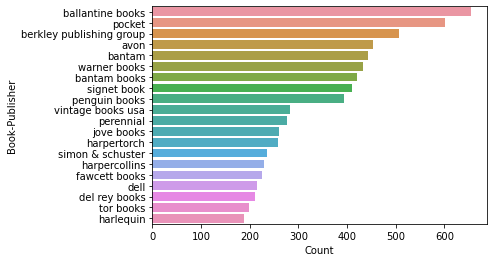

In [53]:
books_publisher = books.groupby(["Book-Publisher"])["ISBN"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'ISBN':'Count'})

sns.barplot(books_publisher.head(20), x = "Count", y = "Book-Publisher", orient = "h")

<Axes: xlabel='Count', ylabel='Book-Publisher'>

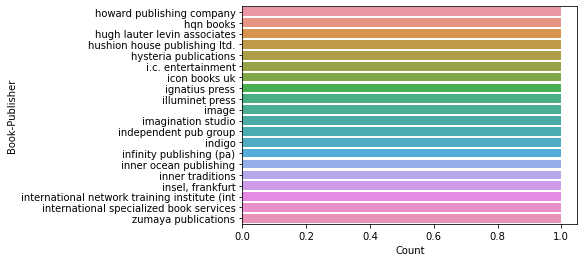

In [54]:
sns.barplot(books_publisher.tail(20), x = "Count", y = "Book-Publisher", orient = "h")

##### Publisher text cleaning:

In [55]:
books["Book-Publisher"].unique().shape

(1330,)

In [56]:
books["Book-Publisher-Processed"] = books["Book-Publisher"].str.lower()

In [57]:
# Define regex pattern to remove non-alphanumeric characters except '&'
pattern = r'[^a-zA-Z0-9& ]'

# Function to clean text based on regex pattern
def clean_text(text):
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text

In [58]:
# Remove all non-alphabetic characters by replacing them with a space.
books["Book-Publisher-Processed"] = books["Book-Publisher-Processed"].apply(clean_text).str.strip()
# books["Book-Publisher-Processed"] = books["Book-Publisher-Processed"].str.strip()

In [59]:
%%time
publisher_fuzzy_match = fuzzy_match_comparison("Publisher-Processed")
publisher_fuzzy_match.shape

1320
CPU times: user 2.82 s, sys: 110 ms, total: 2.93 s
Wall time: 3.16 s


(411, 3)

In [60]:
publisher_fuzzy_match.head()

,Publisher-Processed_sort,score_sort,match_sort
0,ullstein buchverlage gmbh & co kg ullstein tas,98,ullstein buchverlage gmbh & cokg ullstein tasc
1,harpercollins publisher,98,harpercollins publishers
2,harper collins publishers,98,harpercollins publishers
3,harper collins canada,98,harpercollins canada
4,harper sanfrancisco,97,harpersanfrancisco


## BX-Users

In [62]:
users = pd.read_csv(path + "raw/BX-Users.csv")
users.columns

Index(['User-ID', 'User-City', 'User-State', 'User-Country', 'User-Age'], dtype='object')

In [63]:
users.shape

(48299, 5)

In [64]:
users.dtypes

User-ID          int64
User-City       object
User-State      object
User-Country    object
User-Age        object
dtype: object

## Initial Look 
Null values to deal with:
- User-City: 61
- User-Country: 669
- User-Age: 18952 (39.2% of users)
- User-State: 666

Can see that User-State has empty strings:' '.

strings have white space at beginning - strip these.

Some values in columns have trailing " to remove.

deal with n/a in each columns

In [65]:
users.isna().sum()

User-ID             0
User-City          61
User-State          0
User-Country      669
User-Age        18952
dtype: int64

In [66]:
users[users["User-City"].isna()].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
385,2197,NaN,travelling,"canada""",26
616,3569,NaN,n/a,"usa""",NaN
731,4221,NaN,connecticut,"usa""",NaN
1904,11676,NaN,n/a,"n/a""",NaN
2107,12966,NaN,n/a,"singapore""",28


In [67]:
users[users["User-ID"] == 277124]["User-State"] == ' '

47963    True
Name: User-State, dtype: bool

In [68]:
users[users["User-State"] == " "].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,,NaN,"14"""
133,777,portland,,NaN,"13"""
160,929,king of prussia,,NaN,"36"""
196,1118,cleveland,,"usa""",NaN
198,1131,berkeley,,NaN,"22"""


In [69]:
users[users["User-State"] == " "].shape

(666, 5)

In [70]:
users[users["User-Country"].isna()].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
4,19,weston,,NaN,"14"""
133,777,portland,,NaN,"13"""
160,929,king of prussia,,NaN,"36"""
198,1131,berkeley,,NaN,"22"""
284,1589,clio,michigan,NaN,"50"""


In [71]:
users[users["User-Age"].isna()].head(5)

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,"canada""",NaN
1,9,germantown,tennessee,"usa""",NaN
2,16,albuquerque,new mexico,"usa""",NaN
3,17,chesapeake,virginia,"usa""",NaN
5,26,bellevue,washington,"usa""",NaN


### Remove trailing ":

In [72]:
users["User-Country"].str.rstrip('"')

0            canada
1               usa
2               usa
3               usa
4               NaN
            ...    
48294        canada
48295        canada
48296           usa
48297     australia
48298           usa
Name: User-Country, Length: 48299, dtype: object

In [73]:
users["User-Country"]

0            canada"
1               usa"
2               usa"
3               usa"
4                NaN
            ...     
48294        canada"
48295        canada"
48296           usa"
48297     australia"
48298           usa"
Name: User-Country, Length: 48299, dtype: object

In [74]:
users["User-City"] = users["User-City"].str.rstrip('"')
users["User-State"] = users["User-State"].str.rstrip('"')
users["User-Country"] = users["User-Country"].str.rstrip('"')
users["User-Age"] = users["User-Age"].str.rstrip('"')

In [76]:
users.head(1)

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,NaN


## User-ID
No duplicates

In [77]:
users[users["User-ID"].duplicated()]

,User-ID,User-City,User-State,User-Country,User-Age


## User-City

<Axes: xlabel='Count', ylabel='User-City'>

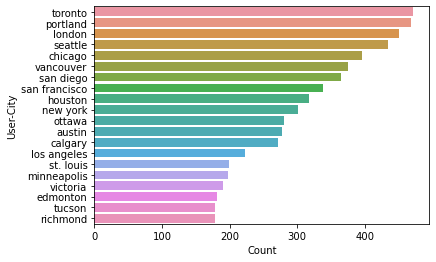

In [78]:
users_city = users.groupby(["User-City"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_city.head(20), x = "Count", y = "User-City", orient = "h")

<Axes: xlabel='Count', ylabel='User-City'>

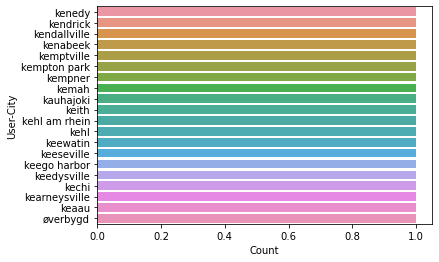

In [79]:
sns.barplot(users_city.tail(20), x = "Count", y = "User-City", orient = "h")

## User-State

<Axes: xlabel='Count', ylabel='User-State'>

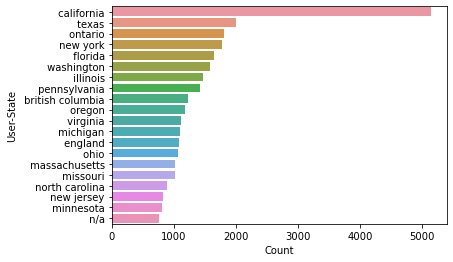

In [80]:
users_state = users.groupby(["User-State"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_state.head(20), x = "Count", y = "User-State", orient = "h")

<Axes: xlabel='Count', ylabel='User-State'>

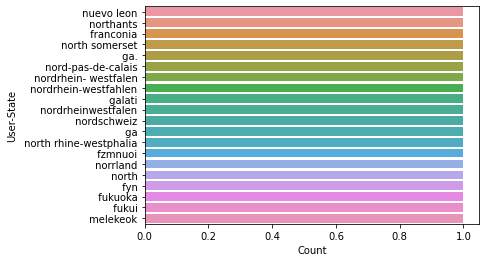

In [81]:
sns.barplot(users_state.tail(20), x = "Count", y = "User-State", orient = "h")

## User-Country

Text(0.5, 1.0, 'Top 10 Countries Users are from')

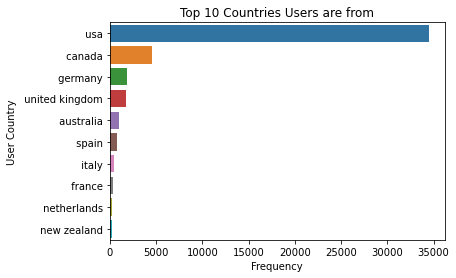

In [161]:
# dataset is mainly from the usa
users_country = users.groupby(["User-Country"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_country.head(10), x = "Count", y = "User-Country", orient = "h")
plt.xlabel('Frequency')
plt.ylabel('User Country')
plt.title('Top 10 Countries Users are from')

<Axes: xlabel='Count', ylabel='User-Country'>

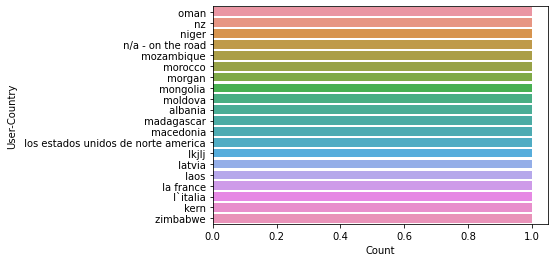

In [83]:
sns.barplot(users_country.tail(20), x = "Count", y = "User-Country", orient = "h")

In [208]:
# USA users count
users_country['Count'][0] 

34465

In [211]:
# USA users percentage
round(100 * users_country['Count'][0]/users_country['Count'].sum(),2)

72.36

## User-Age
- Ages that are NaN set to -1 and removed for analysis.
- Impute mean, based on other features.
- Ages above ~100 outliers and less than 5 don't make sense
- Average age is 36.2.

<Axes: xlabel='Count', ylabel='User-Age'>

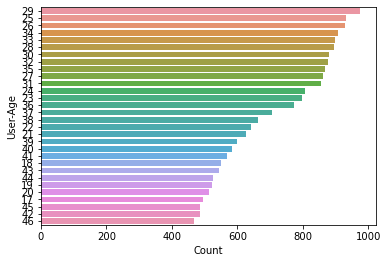

In [75]:
users_age = users.groupby(["User-Age"])["User-ID"].count() \
    .sort_values(ascending = False).reset_index().rename(columns= {'User-ID':'Count'})

sns.barplot(users_age.head(30), x = "Count", y = "User-Age", orient = "h")

<Axes: xlabel='Count', ylabel='User-Age'>

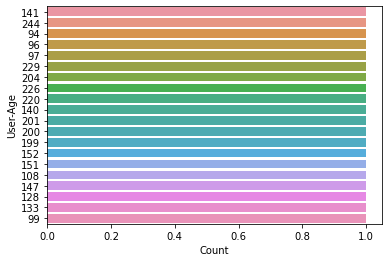

In [76]:
sns.barplot(users_age.tail(20), x = "Count", y = "User-Age", orient = "h")

In [87]:
users["User-Age"] = users["User-Age"].fillna(-1).astype(int)

/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'User Age Distribution with NaN')

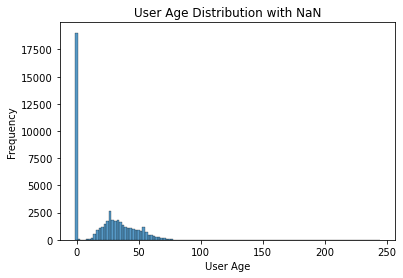

In [88]:
sns.histplot(users, x = "User-Age")
plt.xlabel('User Age')
plt.ylabel('Frequency')
plt.title('User Age Distribution with NaN')

In [89]:
users_age = users[users["User-Age"] != -1]

/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'User Age Distribution without NaN')

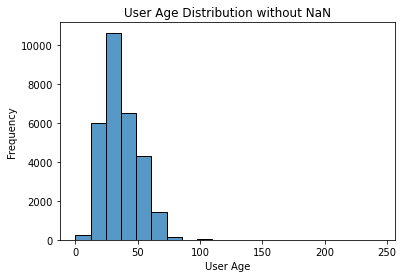

In [91]:
sns.histplot(users_age, x = "User-Age", bins = 20)
plt.xlabel('User Age')
plt.ylabel('Frequency')
plt.title('User Age Distribution without NaN')

In [81]:
users_age.describe()

,User-ID,User-Age
count,29347.000000,29347.000000
mean,139454.265751,36.204178
std,80448.399162,14.681020
min,19.000000,0.000000
25%,69601.000000,26.000000
50%,138514.000000,34.000000
75%,209461.000000,45.000000
max,278852.000000,244.000000


<Axes: xlabel='User-Age'>

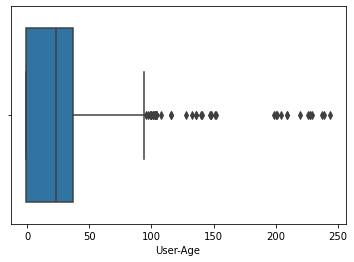

In [82]:
# all ages including nans
sns.boxplot(users, x = "User-Age")

Text(0.5, 1.0, 'Boxplot of Users Age (Age >= 5 and Age <= 100')

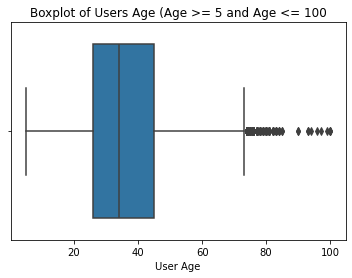

In [162]:
# valid age range
sns.boxplot(users[(users['User-Age'] >= 5) & (users['User-Age'] <= 100)], x = "User-Age")
plt.xlabel('User Age')
plt.title('Boxplot of Users Age (Age >= 5 and Age <= 100')

In [212]:
users[(users['User-Age'] >= 5) & (users['User-Age'] <= 100)].describe()
# mean = 36.17
# sd = 13.66

,User-ID,User-Age
count,29166.000000,29166.000000
mean,139426.439724,36.168587
std,80447.358463,13.660521
min,19.000000,5.000000
25%,69568.000000,26.000000
50%,138386.000000,34.000000
75%,209423.750000,45.000000
max,278852.000000,100.000000


/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='User-Age', ylabel='Count'>

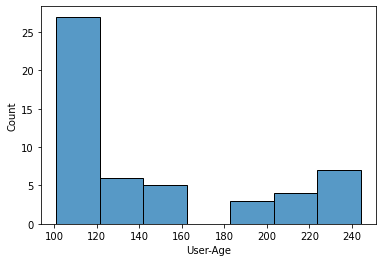

In [83]:
# count of users outside age range
sns.histplot(users[users["User-Age"] > 100], x = "User-Age")

In [86]:
users[users["User-Age"] > 95].head(10)

,User-ID,User-City,User-State,User-Country,User-Age
591,3437,honolulu,hawaii,usa,103
1483,8782,calgary,alberta,canada,239
2056,12692,jacksonville,florida,usa,151
2158,13273,harrisburg,pennsylvania,usa,201
2233,13801,burlington,ontario,canada,104
3368,20857,stuttgart,baden-wuerttemberg,germany,244
4319,26083,leipzig,sachsen,NaN,104
4682,28091,fort collins,colorado,usa,128
5145,30590,cambridge,cambridgeshire,united kingdom,141
5595,32642,boston,massachusetts,usa,103


## BX-ratings
No Nulls



In [96]:
ratings = pd.read_csv(path + "raw/BX-Ratings.csv")
ratings.columns

ratings["User-ID"] = ratings["User-ID"].astype(str)

In [97]:
ratings.head(5)

,User-ID,ISBN,Book-Rating
0,276744,038550120X,7
1,276754,0684867621,8
2,276755,0451166892,5
3,276762,0380711524,5
4,276772,0553572369,7


In [98]:
ratings.dtypes

User-ID        object
ISBN           object
Book-Rating     int64
dtype: object

In [99]:
ratings.isna().sum()

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64

In [100]:
ratings.describe()

,Book-Rating
count,204164.000000
mean,7.719676
std,1.791132
min,1.000000
25%,7.000000
50%,8.000000
75%,9.000000
max,10.000000


In [124]:
ratings_tmp = ratings.copy()
ratings_tmp['Book-Rating'] = ratings_tmp['Book-Rating']
ratings_tmp = ratings_tmp.groupby('Book-Rating')['ISBN'].count().reset_index()

In [127]:
ratings_tmp['Book-Rating'] = ratings_tmp['Book-Rating'].astype(str)

Text(0.5, 1.0, 'Distribution of Book Ratings')

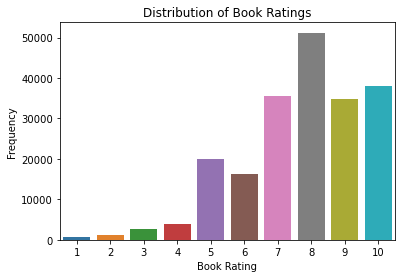

In [129]:
sns.barplot(ratings_tmp, y = "ISBN", x = 'Book-Rating')
plt.xlabel('Book Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Book Ratings')

<Axes: xlabel='Book-Rating'>

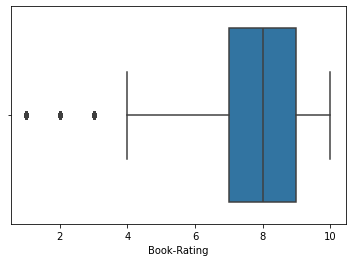

In [102]:
# distribution of ratings
sns.boxplot(ratings, x = "Book-Rating")

In [98]:
ratings.groupby("User-ID")["ISBN"].count().reset_index().rename(columns = {"ISBN":"Count"}).sort_values("Count")

,User-ID,Count
0,100002,1
28015,245668,1
28010,245652,1
28006,24562,1
28004,245610,1
...,...,...
2687,114368,432
12967,16795,516
10377,153662,603
47994,98391,1174


<Axes: xlabel='Count', ylabel='User-ID'>

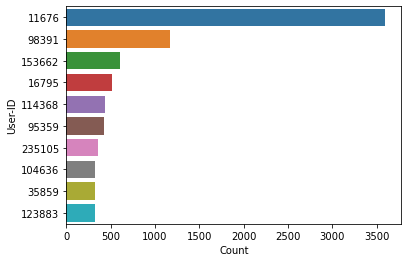

In [99]:
# some users are very active in reviewing books
ratings_users = ratings.groupby(["User-ID"])["ISBN"].count() \
    .reset_index().rename(columns= {'ISBN':'Count'}).sort_values(by = "Count",ascending = False)

sns.barplot(ratings_users.head(10), x = "Count", y = "User-ID", orient = "h")

<Axes: xlabel='Count', ylabel='User-ID'>

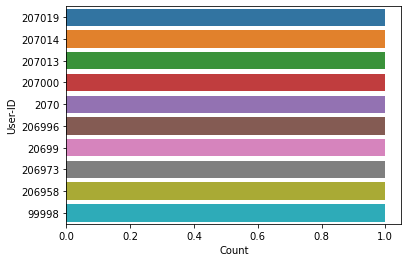

In [100]:
sns.barplot(ratings_users.tail(10), x = "Count", y = "User-ID", orient = "h")

In [101]:
ratings_user_average = ratings.groupby(["User-ID"])["Book-Rating"].mean() \
     .reset_index().rename(columns= {'Book-Rating':'Average'}).sort_values(by = "Average",ascending = False)
ratings_user_average.head()

,User-ID,Average
21853,21468,10.0
5720,12972,10.0
45594,85549,10.0
45593,85540,10.0
25633,234016,10.0


In [102]:
ratings_user_average = ratings.groupby(["User-ID"])["Book-Rating"].mean() \
     .reset_index().rename(columns= {'Book-Rating':'Average'}).sort_values(by = "Average",ascending = False)
ratings_user_average.head()

,User-ID,Average
21853,21468,10.0
5720,12972,10.0
45594,85549,10.0
45593,85540,10.0
25633,234016,10.0


### Merge ratings with BX-Books to see titles

In [191]:
ratings = ratings.merge(books)

In [192]:
ratings_book = ratings.groupby(["ISBN","Book-Title"]).agg(average_rating = ("Book-Rating","mean"),
                                                   times_reviewed = ("Book-Rating","count")). \
            reset_index().sort_values(["average_rating", "times_reviewed"], ascending = [False, True])
ratings_book.head(20)

,ISBN,Book-Title,average_rating,times_reviewed
342,0060280034,dinotopia: a land apart from time (dinotopia),10.0,4
345,0060281375,the complete chronicles of narnia,10.0,4
1156,006440546X,betsy and joe (betsy & tacy),10.0,4
1759,0140431683,heart of darkness (english library),10.0,4
1823,0140501711,make way for ducklings (picture puffins),10.0,4
2035,0152047379,the borrowers,10.0,4
3401,0345368983,the chronicles of pern: first fall (the dragon...,10.0,4
4576,0375727191,the laramie project (vintage originals),10.0,4
5796,0393048470,the annotated alice: the definitive edition,10.0,4
5981,0394829204,there's a wocket in my pocket!,10.0,4


/Users/caseyhaseloff/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='times_reviewed', ylabel='Count'>

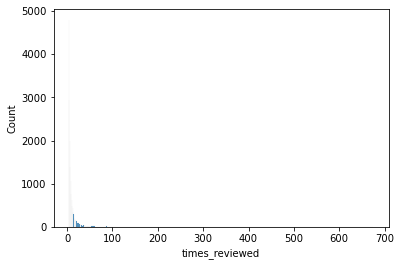

In [193]:
# distribution of times books reviewed 
sns.histplot(ratings_book, x = 'times_reviewed')

In [213]:
q = np.quantile(list(ratings_book["times_reviewed"]), 0.995)

In [214]:
ratings_book[ratings_book['times_reviewed'] > q].sort_values('average_rating', ascending = False)

,ISBN,Book-Title,average_rating,times_reviewed
6911,0439139597,harry potter and the goblet of fire (book 4),9.311111,135
6909,0439136369,harry potter and the prisoner of azkaban (book 3),9.068702,131
6908,0439136350,harry potter and the prisoner of azkaban (book 3),9.035461,141
6925,043935806X,harry potter and the order of the phoenix (boo...,9.024510,204
7754,0446310786,to kill a mockingbird,8.946078,204
...,...,...,...,...
4565,0375725784,a heartbreaking work of staggering genius,7.194245,139
9439,0452282829,we were the mulvaneys,7.059259,135
3813,0345443284,while i was gone,7.000000,133
1646,0140293248,the girls' guide to hunting and fishing,6.924528,159


In [226]:
q = np.quantile(list(ratings_author['times_reviewed']), 0.999)

In [227]:
ratings_author = ratings.groupby(["Book-Author"]).agg(average_rating = ("Book-Rating","mean"), times_reviewed = ("Book-Rating","count")).reset_index()
ratings_author[ratings_author['times_reviewed'] > q].sort_values(['average_rating', 'times_reviewed'], ascending = False)

,Book-Author,average_rating,times_reviewed
2488,J. K. Rowling,8.984185,1644
2766,Janet Evanovich,7.952449,1409
5762,Stephen King,7.873569,4192
2694,James Patterson,7.709879,2237
4684,Nora Roberts,7.629546,2667
4239,Mary Higgins Clark,7.570648,1465
3079,John Grisham,7.521557,2389


In [148]:
ratings_stats = ratings.groupby(["Book-Title", "Book-Author", "Book-Publisher"]) \
    .agg(average_rating = ("Book-Rating","mean"), times_reviewed = ("Book-Rating","count")).reset_index()

In [151]:
ratings_stats = ratings_stats[ratings_stats['times_reviewed'] > 250].sort_values('times_reviewed', ascending = False)

<Axes: xlabel='times_reviewed', ylabel='average_rating'>

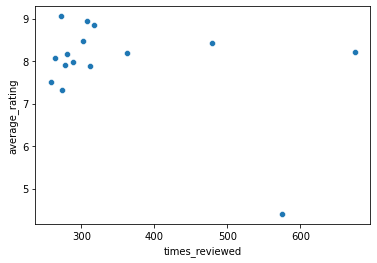

In [155]:
sns.scatterplot(ratings_stats, x = "times_reviewed", y = "average_rating")

### Extended look into combining datasets

In [231]:
users["User-ID"] = users["User-ID"].astype(str)

In [232]:
users

,User-ID,User-City,User-State,User-Country,User-Age
0,8,timmins,ontario,canada,-1
1,9,germantown,tennessee,usa,-1
2,16,albuquerque,new mexico,usa,-1
3,17,chesapeake,virginia,usa,-1
4,19,weston,,NaN,14
...,...,...,...,...,...
48294,278846,toronto,ontario,canada,23
48295,278849,georgetown,ontario,canada,23
48296,278851,dallas,texas,usa,33
48297,278852,brisbane,queensland,australia,32


In [236]:
ratings = ratings.merge(users)

ratings.head()

,User-ID,ISBN,Book-Rating,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Title-Processed,Book-Publisher-Processed,Book-Info,User-City,User-State,User-Country,User-Age
0,276754,0684867621,8,the girl who loved tom gordon : a novel,Stephen King,1999,scribner,stephen king,the girl who loved tom gordon a novel,scribner,the girl who loved tom gordon a novel by steph...,alberta beach,alberta,canada,19
1,276755,0451166892,5,the pillars of the earth,Ken Follett,1996,signet book,ken follett,the pillar of the earth,signet book,the pillar of the earth by ken follett,frankfurt am main,hessen,germany,32
2,276762,0380711524,5,see jane run,Joy Fielding,1992,avon,joy fielding,see jane run,avon,see jane run by joy fielding,duisburg,nordrhein-westfalen,germany,25
3,276796,0330332775,5,bridget jones's diary,Helen Fielding,1997,picador (uk),helen fielding,bridget jones s diary,picador uk,bridget jones s diary by helen fielding,manchester,england,united kingdom,21
4,276798,3548603203,6,artemis fowl.,Eoin Colfer,2003,ullstein tb-vlg,eoin colfer,artemis fowl,ullstein tbvlg,artemis fowl by eoin colfer,mannheim,baden-wuerttemberg,germany,31


In [237]:
ratings = ratings[(ratings['User-Age'] >= 5) & (ratings['User-Age'] <= 100)]

<Axes: >

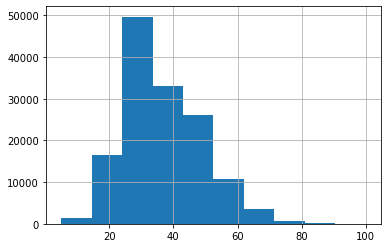

In [238]:
# distribution of reviews within valid age range
ratings['User-Age'].hist()

<Axes: xlabel='count', ylabel='mean'>

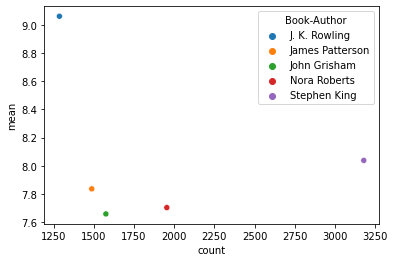

In [239]:
# average rating by author
ratings_avg_age = ratings.groupby(["Book-Author"]) \
    .agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count"), average_age = ("User-Age", "mean")) \
    .reset_index()
sns.scatterplot(ratings_avg_age[ratings_avg_age["count"] > 1000], x = "count", y = "mean", hue = "Book-Author")

<Axes: xlabel='count', ylabel='average_age'>

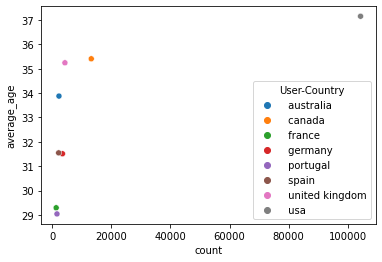

In [240]:
# average age of users by country
ratings_avg_age = ratings.groupby(["User-Country"]) \
    .agg(mean = ("Book-Rating","mean"), count = ("Book-Rating","count"), average_age = ("User-Age", "mean")) \
    .reset_index()
sns.scatterplot(ratings_avg_age[ratings_avg_age["count"] > 1000], x = "count", y = "average_age", hue = "User-Country")

In [241]:
ratings_avg_age

,User-Country,mean,count,average_age
0,afghanistan,1.5,2,52.5
1,algeria,6.0,1,34.0
2,america,8.0,5,26.0
3,angola,8.0,1,51.0
4,antigua and barbuda,8.0,1,35.0
...,...,...,...,...
126,vietnam,8.0,2,22.0
127,wales,6.0,1,42.0
128,ysa,9.0,1,32.0
129,yugoslavia,7.0,3,22.0


In [243]:
publication = ratings.groupby(['ISBN', 'Book-Info', 'Year-Of-Publication']).agg(average_age = ("User-Age", "mean"),
                                                                  average_rating = ("Book-Rating", "mean"),
                                                                    times_reviewed = ("User-ID", "count")).reset_index()

In [244]:
# books reviewed more than 50 times
publication = publication[publication['times_reviewed'] > 50]

<Axes: xlabel='Year-Of-Publication', ylabel='average_age'>

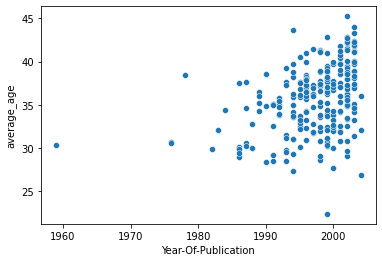

In [245]:
# average age of reader compared to year of publication of book
sns.scatterplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = "Year-Of-Publication", y = "average_age")

<Axes: xlabel='Year-Of-Publication', ylabel='average_rating'>

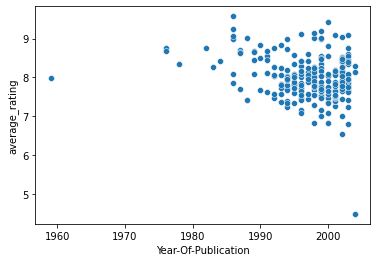

In [246]:
# average rating compared to year of publication per book
sns.scatterplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = "Year-Of-Publication", y = "average_rating")

<Axes: xlabel='average_age', ylabel='average_rating'>

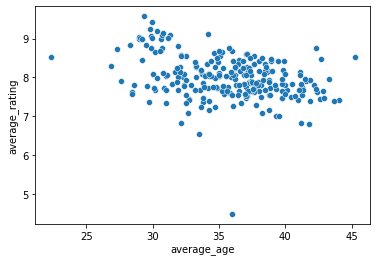

In [247]:
# average rating compared to average age per book
sns.scatterplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = "average_age", y = "average_rating")

In [248]:
publication = ratings.groupby(['ISBN', 'Book-Info', 'Year-Of-Publication', 'User-Country']).agg(average_age = ("User-Age", "mean"),
                                                                  average_rating = ("Book-Rating", "mean"),
                                                                    times_reviewed = ("User-ID", "count")).reset_index()

In [249]:
# books are reviewed by at least 5 users in country
publication = publication[publication['times_reviewed'] > 5]

In [252]:
publication.head(1)

,ISBN,Book-Info,Year-Of-Publication,User-Country,average_age,average_rating,times_reviewed
42,000649840X,angelas ash by frank mccourt,0,united kingdom,32.058824,8.0,17


<Axes: xlabel='Year-Of-Publication', ylabel='average_age'>

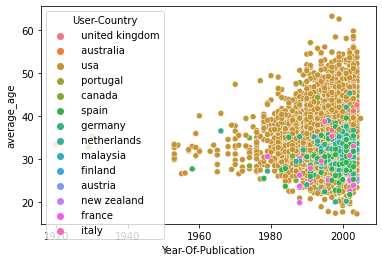

In [253]:
sns.scatterplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = "Year-Of-Publication", y = "average_age", hue = 'User-Country')

<Axes: xlabel='Year-Of-Publication', ylabel='average_rating'>

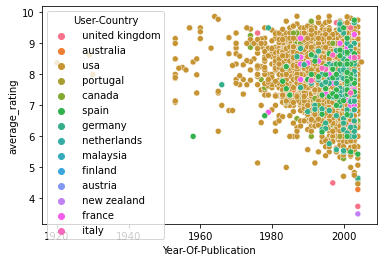

In [254]:
sns.scatterplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = "Year-Of-Publication", y = "average_rating", hue = 'User-Country')

<Axes: xlabel='average_age', ylabel='average_rating'>

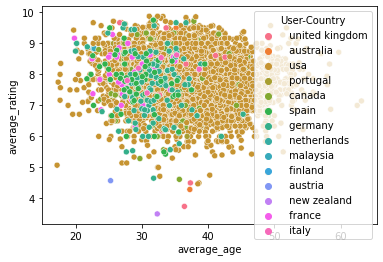

In [255]:
sns.scatterplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = "average_age", y = "average_rating", hue = 'User-Country')

<Axes: xlabel='average_rating', ylabel='User-Country'>

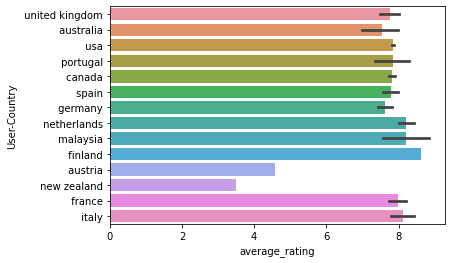

In [256]:
# spread of average rating by country
sns.barplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = 'average_rating', y = 'User-Country')

<Axes: xlabel='average_age', ylabel='User-Country'>

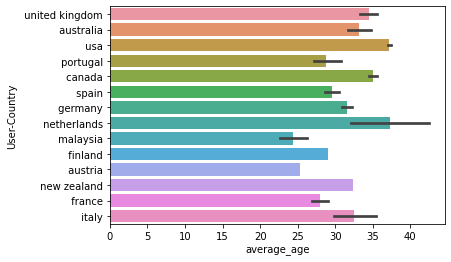

In [257]:
# spread of average age by country
sns.barplot(publication[(publication['Year-Of-Publication'] != 0) & 
                (publication['Year-Of-Publication'] < 2030)], x = 'average_age', y = 'User-Country')